### Suffix tree construction

To be able to optimize the search for patterns within strings we need to do a couple of steps.
Firstly we need to construct a suffix tree that we can search through.
For this construction the most naive version would take O(n^2) time to construct and O(n^2) space
However it is possible to optimize it to O(n) runtime and O(n) space
Space can be optimized by change the edges from symbols to idx
runtime can be optimized by...

#### Naive construction

In [3]:
def construct_suffix_tree(s):
    # First we add $ to the string
    s = s + '$'
    suffix_tree = {}
    
    # make list of all suffixes
    suffixes = [s[i:] for i in range(len(s))]
    
    # insert suffixes
    for suffix in suffixes:
        starting_char = suffix[0]
        if starting_char not in suffix_tree:
            suffix_tree[starting_char] = []
        
        # Append the suffix to the list for the starting character
        suffix_tree[starting_char].append(suffix)
    
    # Return the suffix tree dictionary
    return suffix_tree

# Run the algoo
s = "banana"
suffix_tree = construct_suffix_tree(s)
print(suffix_tree)

{'b': ['banana$'], 'a': ['anana$', 'ana$', 'a$'], 'n': ['nana$', 'na$'], '$': ['$']}


Above might not give a usefull output. below is an outline of the algorithm 

In [ ]:
# Start at the root of Ni


# Find the longest path from the root which matches a prefix of S[i+1..m]$


# Match ends either at the node (say w) or in the middle of an edge [say (u, v)].


# If it is in the middle of an edge (u, v), break the edge (u, v) into two edges 
# by inserting a new node w just after the last character on the edge that matched a 
# character in S[i+l..m] and just before the first character on the edge that mismatched. 
# The new edge (u, w) is labelled with the part of the (u, v) label that matched with S[i+1..m], 
# and the new edge (w, v) is labelled with the remaining part of the (u, v) label.


# Create a new edge (w, i+1) from w to a new leaf labelled i+1 and it labels the new edge with 
# the unmatched part of suffix S[i+1..m]

##### Class based construction of a trie
Below a class was constructed to represent the nodes that points towards their children nodes. This can be used to form a tree of the letters found in each suffix.

In [235]:
from graphviz import Digraph

class SuffixTreeNode:
    def __init__(self):
        self.children = {}          # Dictionary to hold children nodes (edge label -> child node)
        self.index = -1             # Position in string
        self.suffix_number = None     # placeholder for final index of a suffix


class SuffixTree:

    ####################################
    ########## Construction ############
    def __init__(self, text):
        self.text = text + "$"              # add $
        self.root = SuffixTreeNode()        
        self.build_suffix_tree()            # use function to build suffixtree

    def build_suffix_tree(self):
        """
        build the suffix tree inserting all suffixes of the string we give
        """
        n = len(self.text)
        
        for i in range(n):
            current_node = self.root
            suffix = self.text[i:]  # slice the string to make suffixes (i starts with 0 so all of the string first)
            for idx in range(len(suffix)):
                if suffix[idx] not in current_node.children: # character not found, create a new node
                    current_node.children[suffix[idx]] = SuffixTreeNode()
                current_node = current_node.children[suffix[idx]]  # Move to the child node we just made
                current_node.index = i      
            current_node.suffix_number = i  # updates the index when suffix is placed

    ###############################
    ####### Visualization #########
    def visualize(self, filename="suffix_tree"):
        """
        Visualize the suffix tree using Graphviz.
        """
        # create Graphviz object 
        dot = Digraph(node_attr={'shape': 'ellipse', 'fontsize': '12', 'fixedsize': 'false'},
                      edge_attr={'fontsize': '10', 'fontcolor': 'blue', 'labelfontsize': '10', 
                                 'labeldistance': '1', 'labelangle': '0'})
        self._visualize_helper(self.root, dot)
        dot.render(filename, format='png', cleanup=True)    # saves an image of the tree in root folder
        print(f"Visualization saved as {filename}.png")
        return dot

    def _visualize_helper(self, node, dot, parent_id="root", edge_label=""):
        """
        Helper function - add nodes and edges to the Graphviz object.
        """
        node_id = str(id(node))
        
        # Node label - if suffix_number defined we create a label indicating the order the suffixes where added. only nodes with $ get a label
        if node.suffix_number != None:
            label = f"({node.suffix_number})"
        else:
            label = ""

        # adjust node size in Digraph object
        dot.node(node_id, label, width="0.5", height="0.5", style="filled", color="lightgrey")

        # add edge from parent to current node
        if parent_id != "root":
            dot.edge(parent_id, node_id, label=edge_label, fontsize="25", fontcolor="red")  # add and adjust edge text fpr digraph

        # Recursively add children
        for char, child_node in node.children.items():
            self._visualize_helper(child_node, dot, node_id, edge_label=char)


    ########################################
    ######## Additional functions ##########    
    def find_longest_branch(self):
        """
        Find the longest branch in the suffix tree
        Returns both the longest str and the length
        """
        # using depth first search
        def dfs(node, current_path):
            nonlocal max_length, longest_string 
            if node.index != -1:                    # if leaf, then chek if current path is longest we have looked at yet
                if len(current_path) > max_length: 
                    max_length = len(current_path)
                    longest_string = current_path
            
            # traverse all children recursively
            for char, child_node in node.children.items():
                dfs(child_node, current_path + char)

        # Initialize variables
        max_length = 0
        longest_string = ""
        # Start DFS from the root
        dfs(self.root, "")

        return max_length, longest_string


    def get_all_suffixes(self):
        """
        Collect all suffixes stored in the suffix tree by DFS
        Returns a list of all the suffixs in the tree
        """
        suffixes = []

        def dfs(node, current_suffix):
            # if leaf -> add suffix to list
            if node.suffix_number != None:
                suffixes.append(current_suffix)
            
            # Recursively traverse all children
            for char, child_node in node.children.items():
                dfs(child_node, current_suffix + char)

        # Start DFS from the root
        dfs(self.root, "")
        
        return suffixes


In [234]:
# usage
string = "banana"
suffix_tree = SuffixTree(string)


#### Validating the suffix trees

When the tree construction is complete, its a very good idea to validate if the trees are actually suffix trees. To do this we can check the different criteria that such a tree has and check if our trees generated follow those criteria.

Criteria we could potentially check:
- Spelling of the substring is correct, so we check if the longest string is the same length and is spell the same way as the original string
- Every node only has outgoing edges with unique starting symbols
- Check that every suffix possible is accounted for. There should be the same number of 
'$' as there are suffixes 

Below are some typical test sequences used as examples

##### Confirming criterias

Lets try to confirm some of the criteria outlined above. Lets start by investigating the longest branch in the tree

In [238]:
# defining a test string we wanna use and making the tree
string = "banana"
string_s = string + "$"         # add $ to string
suffix_tree = SuffixTree(string)

print("suffix_tree was generated with the string:", string)


#### Find longest branch in suffix tree #####
length, longest_branch = suffix_tree.find_longest_branch()
input_length = len(string_s)

print("\n### The length check ###")
print("Longest branch is:", length, "length and it is:", longest_branch)
print("Input string is:", input_length, "length and it is:", string_s)

#### Spell checking ####
print("\n### The spell check ###")
print("spelled correctly?", longest_branch == string_s)

#### Double check every suffix is in tree ####
actual_suffixes = sorted(suffix_tree.get_all_suffixes())
expected_suffixes = sorted([string_s[i:] for i in range(len(string_s))])
print("\n### Check all suffixes are present ###")
print("Suffixes found in tree:", actual_suffixes)
print("Expected suffixes:", expected_suffixes)
print("same?", actual_suffixes == expected_suffixes)

suffix_tree was generated with the string: banana

### The length check ###
Longest branch is: 7 length and it is: banana$
Input string is: 7 length and it is: banana$

### The spell check ###
spelled correctly? True

### Check all suffixes are present ###
Suffixes found in tree: ['$', 'a$', 'ana$', 'anana$', 'banana$', 'na$', 'nana$']
Expected suffixes: ['$', 'a$', 'ana$', 'anana$', 'banana$', 'na$', 'nana$']
same? True


##### Visualize the tree

Firstly using the function visualize and visualize helper. we can generate an image of the trees we make with graphviz.

Visualization saved as suffix_tree.png


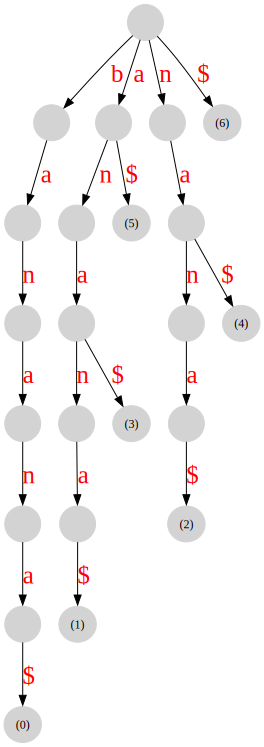

In [237]:
string = "banana"
suffix_tree = SuffixTree(string)

# Visualize the tree using Graphviz
graph = suffix_tree.visualize()
display(graph)

#### Compressed Trie - suffix tree
This solution does give us a suffix tree that we could search through. But it takes O(n^2) time and space. This can be speed up to a potential O(n+m) if we instead compress the the tree.
Instead of having a single charater on each edge, we can have indices representing slices of the original string. this enables us to not have as many nodes to construct and eventually check. 


Current ideas:
- we craft the original tree and then look through it and compress all the segments where there are only 1 child (Not good for construction time)
- all edges start out as their full suffix indicated by their index. When new suffixes add more than what would have been 1 child node we split the original index. 
- We dont add one suffix at a time, but instead add every suffix incrementally 


book uses:
- range defined by start and end of the slice
- a parent list
- a child list
- a sibling list
- a suffix link

helper function edge_length:
gets the edge_length start -> end (range)

suffix_tree functin
string
length
root


new_node function


In [365]:
# book outline
# idea is to add entire suffixes at a time, if no outgoing node matches the current
# suffix then we add it as a single node where the edge is the indices representng 
# suffix. If we find an edge our current suffix matches with we more along the edge
# and check if the characters are the same, if not we create a split.
# After a split we can add the rest of the current suffix as its own node
# and we need to update the indices on the edge we just followed, aswell as the later
# part of that edge.

# see page 99 in mailund book. We need to ensure that our nodes/edges holds
# the information about their from -> to so that when we update them we can 
# edit these, this information is what our edges should hold.

# (book uses a list for parents, siblings and children. My implemenation only uses a dict for children)


# class node



# def naive insert
    # def find outgoing edges
    # 

# def find outgoing edge

# def split edge




class Node(object):
    def __init__(self, start=None, end=None, suffix_number=None, parent=None):
        self.start = start                      # start idx for string
        self.end = end                          # end idx for string 
        self.suffix_number = suffix_number      # order the $ are add to tree
        self.children = {}                      # children as dictionary, key = a unique charater, value = Npde(object)
        self.parent = parent                    # Defining a parent node allows us to go back up in the tree

    
class SuffixTree:
    def __init__(self, string):
        self.string = string + "$"
        self.root = Node()
        self.build_tree(string)
    
    
    def build_tree(self, string):
        string = string + "$"
        n = len(string)
        
        root_node = self.root # we should node edit the root itself so defined for later

        for i in range(n):
            current_node = self.root
            suffix = string[i:]
            first_char = suffix[0]

            ### outgoing edge - check if suffix has an edge it can follow
            # No children - so we add one
            if first_char not in current_node.children:
                # print("made new", first_char)
                current_node.children[first_char] = Node(i, n-1, i, current_node)       
            
            # We have an outgoing edge!
            elif first_char in current_node.children:
                # print("already there", first_char)
                current_node = current_node.children[first_char] # move down to the node we found
                edge = string[current_node.start:current_node.end]

                # follow edge until no longer the same char
                for s in range(len(edge)-1):
                    if edge[s] != suffix[s]:
                        break

                s = s + current_node.start ### <---------this gives indexing error
                ### split edge - Make a new node inbetween parent and child node, and add the rest of the new suffix as a new child
                # update old child node to start idx s 
                # current_node.start = s

                # add inbetween node to the parent and current
                new_node = Node(i, s, None, current_node.parent)

                print(i, edge[0], edge)
                current_node.parent.children[edge[0]] = new_node  # key overwrites

                # transfer child to newly made node 
                new_key = string[s-1]
                current_node.start = s
                new_node.children[new_key] = current_node

                current_node.parent = new_node

                # Move to the newly made split node
                current_node = current_node.parent
                # andadd the new suffix
                current_node.children[suffix[0]] = Node(s, n-1, i, current_node)

                # move back to root before repeating
                current_node = root_node


                # code i made above might be a little wrong indexing wise
                # it needs to take the indices from the full string, not from
                # the edges
                # Could also be caused by overwriting a key in the dictionary?

                
    def visualize(self, filename="suffix_tree"):
        """
        Visualize the suffix tree using Graphviz.
        """
        # create Graphviz object 
        dot = Digraph(node_attr={'shape': 'ellipse', 'fontsize': '12', 'fixedsize': 'false'},
                      edge_attr={'fontsize': '10', 'fontcolor': 'blue', 'labelfontsize': '10', 
                                 'labeldistance': '1', 'labelangle': '0'})
        self._visualize_helper(self.root, dot)
        dot.render(filename, format='png', cleanup=True)    # saves an image of the tree in root folder
        print(f"Visualization saved as {filename}.png")
        return dot

    def _visualize_helper(self, node, dot, parent_id="root", edge_label=""):
        """
        Helper function - add nodes and edges to the Graphviz object.
        """
        node_id = str(id(node))
        
        # Node label - if suffix_number defined we create a label indicating the order the suffixes where added. only nodes with $ get a label
        if node.suffix_number != None:
            label = f"({node.suffix_number})"
        else:
            label = ""

        # adjust node size in Digraph object
        dot.node(node_id, label, width="0.5", height="0.5", style="filled", color="lightgrey")

        # add edge from parent to current node
        if parent_id != "root":
            dot.edge(parent_id, node_id, label=edge_label, fontsize="25", fontcolor="red")  # add and adjust edge text fpr digraph

        # Recursively add children
        for char, child_node in node.children.items():
            self._visualize_helper(child_node, dot, node_id, edge_label=char)

    

test = "banana"

suffix_tree = SuffixTree(test)
suffix_tree.root.children['n']

3 a anana
4 n nana
5 a a


3 a anana
4 n nana
5 a a
Visualization saved as suffix_tree.png


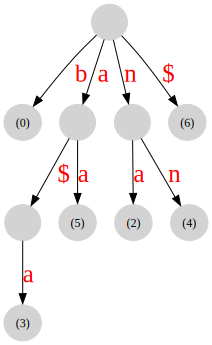

In [360]:
test = "banana"
suffix_tree = SuffixTree(test)

# Visualize the tree using Graphviz
graph = suffix_tree.visualize()
display(graph)